# Performance across learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import *

#temp workaround since it gets removed from the path whenever the kernel is restarted
import sys
sys.path.insert(0, '/Users/gabriel/lib/')
import chiCa

%matplotlib widget

### Define some WIP functions

In [2]:
def get_session_dates(file_names):
    session_dates = []
    for file in file_names:
        split_path = file.split('/')
        session_dates.append(split_path[5]) #with the churchland data folder structure, this corresponds to the date

    return session_dates

def get_session_averages(file_names, min_stims=5):
    session_performance_averages = []
    for file in file_names: 
        session_data = pd.read_hdf(file)
        stim_rates = np.unique(np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps]))
        if len(stim_rates)>min_stims:
            performance = np.array(session_data.outcome_record, dtype=float)
            performance[performance == -1] = np.nan #setting early withdrawal trials as nans
            performance[performance == 2] = np.nan #setting no response trials as nans
            session_performance_averages.append(np.nanmean(performance))

    return session_performance_averages

def get_filtered_session_averages_and_dates(file_names, min_stims=5):
    filtered_dates = []
    filtered_session_averages = []
    stims = []
    for file in file_names:
        session_data = pd.read_hdf(file)
        stim_rates = np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps])
        unique_stims = list(np.unique(stim_rates))
        valid_trials = np.logical_or(stim_rates == 4, stim_rates == 20)
        if len(unique_stims)>min_stims:
            #allocate performance
            performance = np.array(session_data.outcome_record, dtype=float)
            performance[performance == -1] = np.nan #setting early withdrawal trials as nans
            performance[performance == 2] = np.nan #setting no response trials as nans
            filtered_session_averages.append(np.nanmean(performance[valid_trials]))

            #allocate date
            split_path = file.split('/')
            filtered_dates.append(split_path[5])

            #allocate unique_stims
            stims.append(unique_stims)

    return filtered_dates, filtered_session_averages, stims

def get_file_names(animal_name, data_type, file_extension, file_keyword=None):
    '''Tool to select specified files of a data type over all sessions for a given animal.
    This relies on the hierarchical Churchland lab data folder structure with:
    animal_name -> session_datetime -> data_type
    
    Adapted from Lukas Oesch's `chipmunk_analysis_tools.py`.
       
    
    Parameters
    ----------
    animal_name: str, the name of the animal whose sessions are to be selected.
    data_type: str, the directory with the specific data type, for example chipumnk, caiman, etc.
    file_extension: str, file extension specifier, for example *.mat
    file_keyword: str, a pattern that should be detected inside the file name to
                  distinguish the desired files from other files with the same extension.
    
    Returns
    -------
    file_names: list, list of file names selected
    
    Examples
    --------
    file_names = get_file_names('GRB001', 'chipmunk', '*.h5')
    '''
    import os
    import glob
    
    home_dir = os.path.expanduser("~")
    session_dirs = glob.glob(f"{home_dir}/data/{animal_name}/*/")
    
    file_names = []
    for session_dir in session_dirs:
        data_type_dir = os.path.join(session_dir, data_type)
        file_paths = glob.glob(os.path.join(data_type_dir, file_extension))
        for file_path in file_paths:
            if file_keyword is None or file_keyword in file_path:
                file_names.append(file_path)
    
    file_names.sort()
    
    return file_names

def count_stimulus_timestamps(row):
    data = pd.read_hdf(row['path'])
    stimulus_event_timestamps = data['stimulus_event_timestamps']
    trial_lengths = [len(trial) for trial in stimulus_event_timestamps]
    return trial_lengths

def get_response_side(row):
    data = pd.read_hdf(row['path'])
    response_side = np.array(data['response_side'])
    return response_side

### Identify good sessions

In [18]:
#Get performance averages for each session
GRB001_paths = get_file_names('GRB001', 'chipmunk', '*.h5')
GRB002_paths = get_file_names('GRB002', 'chipmunk', '*.h5')
GRB003_paths = get_file_names('GRB003', 'chipmunk', '*.h5')
GRB004_paths = get_file_names('GRB004', 'chipmunk', '*.h5')

paths_all_animals = {'GRB001':GRB001_paths,
                     'GRB002':GRB002_paths,
                     'GRB003':GRB003_paths,
                     'GRB004':GRB004_paths}

group_performance_data = {}

for animalID, paths in paths_all_animals.items():
    # session_dates = get_session_dates(paths)
    # session_averages = get_session_averages_easy_trials_only(paths)
    session_dates, session_averages, unique_stims = get_filtered_session_averages_and_dates(paths, min_stims=5)
    performance_by_day = pd.DataFrame(data={'date':session_dates,'performance average':session_averages, 'unique stims':unique_stims})
    group_performance_data.update({animalID:performance_by_day})

#Filter session dates by performance average value and grab the paths to those sessions
threshold = 0.5
filtered_group_performance_data = {}

for animal_id, performance_data in group_performance_data.items():
    filtered_performance_data = performance_data[performance_data['performance average'] >= threshold].reset_index(drop=True)
    filtered_dates = filtered_performance_data['date'].tolist()
    filtered_paths = []
    for path in paths_all_animals[animal_id]:
        if '/' in path:
            split_path = path.split('/')
            if split_path[5] in filtered_dates:
                filtered_paths.append(path)
    filtered_group_performance_data[animal_id] = {'performance data': filtered_performance_data, 'filtered paths': filtered_paths}

#Store the filtered performance data for each animal
filtered_data_list = []
filtered_path_list = []

for animal_id, data in filtered_group_performance_data.items():
    filtered_data_list.append(data['performance data'])
    # filtered_path_list.append(data['filtered paths'])

# concatenate the filtered performance data for all animals into a single dataframe with animal IDs as keys
concatenated_data = pd.concat(filtered_data_list, keys=filtered_group_performance_data.keys())
concatenated_data = concatenated_data.reset_index().rename(columns={'level_0': 'animal_id', 'level_1': 'row_index'})

# # concatenate the filtered data paths for all animals into a single dataframe with animal IDs as keys
# concatenated_paths = pd.concat(filtered_path_list, keys=filtered_group_performance_data.keys())
# concatenated_paths = concatenated_data.reset_index().rename(columns={'level_0': 'animal_id', 'level_1': 'row_index'})

# print the updated concatenated data
# print(concatenated_data)

## Set up dataframe to store data for GLM-HMM

In [19]:
# assuming filtered_group_performance_data is your dictionary
filtered_paths = []
for animal_id, animal_data in filtered_group_performance_data.items():
    for filtered_path in animal_data['filtered paths']:
        filtered_paths.append([animal_id, filtered_path])

df_filtered_paths = pd.DataFrame(filtered_paths, columns=['animalID', 'path'])

# df_filtered_paths

In [20]:
#add relevant columns to dataframe
df_filtered_paths['data'] = df_filtered_paths['path'].apply(pd.read_hdf)
df_filtered_paths['trials_per_session'] = df_filtered_paths['data'].apply(len)
df_filtered_paths['num_completed_trials'] = df_filtered_paths['data'].apply(lambda x: len(x[x['outcome_record'].isin([-1, 2]) == False]))
df_filtered_paths['stimuli_presented'] = df_filtered_paths.apply(count_stimulus_timestamps, axis=1)
df_filtered_paths['response_side'] = df_filtered_paths.apply(get_response_side, axis=1)
df_filtered_paths['choice'] = df_filtered_paths['response_side'].apply(lambda x: [val for val in x if not pd.isna(val)])
all_data = df_filtered_paths

## EM GLM-HMM

In [21]:
import ssm
from ssm.util import find_permutation

In [22]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

### Creating external input sequences

In [23]:
num_sess = len(all_data) # number of example sessions
num_trials_per_sess = all_data['num_completed_trials'].tolist() # number of trials in a session
stim_vals = [4,6,8,10,12,14,16,18,20]

inpts = []
for i in range(num_sess):
    inpts.append(np.ones((num_trials_per_sess[i], 2), dtype=float))

stimuli = all_data['stimuli_presented']
for i in range(num_sess):
    for j in range(num_trials_per_sess[i]):
        inpts[i][j][0] = stimuli[i][j]

choice = [np.array(lst).reshape(-1, 1).astype(int) for lst in  all_data['choice']]

#seems like it's in the same format as the matrix in the tutorial notebook

### Fit glmhmm

In [24]:
N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = glmhmm.fit(choice, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

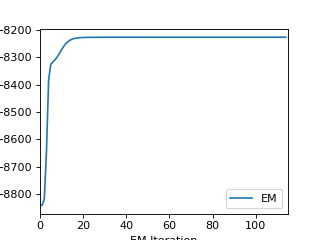

In [25]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
# plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### Recover weights

Text(0.5, 1.0, 'Weight recovery')

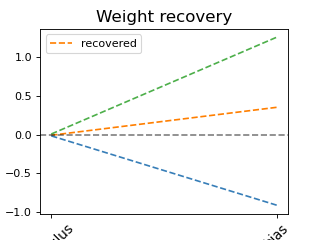

In [26]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = glmhmm.observations.params
for k in range(num_states):
    if k ==0:
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

### Plot transition matrix

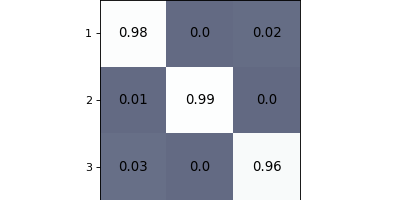

In [27]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')


recovered_trans_mat = np.exp(glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


### Get posterior probabilities

In [28]:
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choice, inpts)]

Text(0, 0.5, 'p(state)')

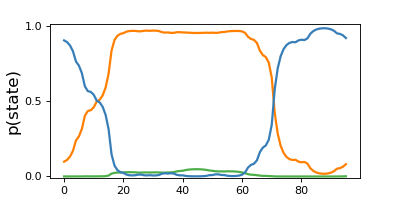

In [29]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

### Get state occupancies

In [30]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

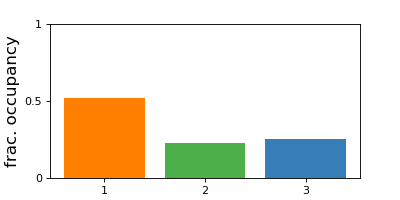

In [31]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

## MAP GLM-HMM

In [32]:
# Instantiate GLM-HMM and set prior hyperparameters
prior_sigma = 2
prior_alpha = 2
map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

In [34]:
# Fit GLM-HMM with MAP estimation:
_ = map_glmhmm.fit(choice, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

In [35]:
# true_likelihood = true_glmhmm.log_likelihood(true_choices, inputs=inpts)
mle_final_ll = glmhmm.log_likelihood(choice, inputs=inpts) 
map_final_ll = map_glmhmm.log_likelihood(choice, inputs=inpts) 

Text(0, 0.5, 'loglikelihood')

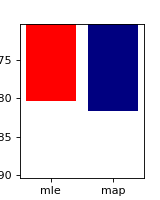

In [40]:
# Plot these values
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_final_ll, map_final_ll]
colors = ['Red', 'Navy']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((mle_final_ll-10, mle_final_ll+10))
plt.xticks([0, 1], ['mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

## Cross-validation

In [41]:
# Create additional input sequences to be used as held-out test data
# num_test_sess = 10
# test_inpts = np.ones((num_test_sess, num_trials_per_sess, input_dim)) 
# test_inpts[:,:,0] = np.random.choice(stim_vals, (num_test_sess, num_trials_per_sess)) 
# test_inpts = list(test_inpts)

#######

# num_sess = len(all_data) # number of example sessions
# num_trials_per_sess = all_data['num_completed_trials'].tolist() # number of trials in a session
# stim_vals = [4,6,8,10,12,14,16,18,20]

# inpts = []
# for i in range(num_sess):
#     inpts.append(np.ones((num_trials_per_sess[i], 2), dtype=float))

# stimuli = all_data['stimuli_presented']
# for i in range(num_sess):
#     for j in range(num_trials_per_sess[i]):
#         inpts[i][j][0] = stimuli[i][j]

# choice = [np.array(lst).reshape(-1, 1).astype(int) for lst in  all_data['choice']]

#######

num_test_sess = 10 # number of example sessions
num_trials_per_test_sess = all_data['num_completed_trials'][:num_test_sess].tolist() # number of trials in a session
stim_vals = [4,6,8,10,12,14,16,18,20]

test_inpts = []
for i in range(num_test_sess):
    test_inpts.append(np.ones((num_trials_per_test_sess[i], 2), dtype=float))

test_stimuli = all_data['stimuli_presented'][:num_test_sess]
for i in range(num_test_sess):
    for j in range(num_trials_per_test_sess[i]):
        test_inpts[i][j][0] = stimuli[i][j]

test_choice = [np.array(lst).reshape(-1, 1).astype(int) for lst in all_data['choice'][:num_test_sess]]

In [42]:
# Compare likelihood of test_choices for model fit with MLE and MAP:
mle_test_ll = glmhmm.log_likelihood(test_choice, inputs=test_inpts) 
map_test_ll = map_glmhmm.log_likelihood(test_choice, inputs=test_inpts) 

Text(0, 0.5, 'loglikelihood')

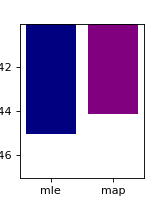

In [43]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_test_ll, map_test_ll]
colors = ['Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((mle_test_ll-2, mle_test_ll+5))
plt.xticks([0, 1], ['mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

Text(0.5, 1.0, 'MAP')

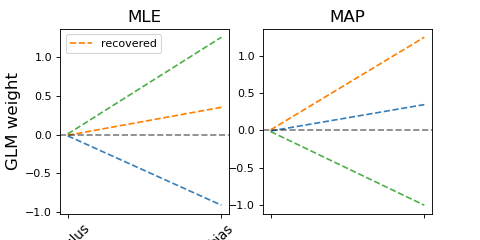

In [44]:
fig = plt.figure(figsize=(6, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
plt.subplot(1,2,1)
recovered_weights = glmhmm.observations.params
for k in range(num_states):
    if k ==0: # show labels only for first state
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = 'recovered', linestyle='--')   
    else:
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle='--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("MLE", fontsize = 15)
plt.legend()

plt.subplot(1,2,2)
recovered_weights = map_glmhmm.observations.params
for k in range(num_states):
    plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                 lw=1.5,  label = '', linestyle='--')
plt.yticks(fontsize=10)
plt.xticks([0, 1], ['', ''], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("MAP", fontsize = 15)

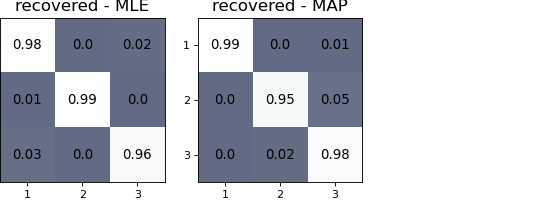

In [45]:
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
recovered_trans_mat = np.exp(glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered - MLE", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


plt.subplot(1, 3, 2)
recovered_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered - MAP", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

### Plot performance across days

In [ ]:
#Get the average performance across days for one animal
file_names = chiCa.pick_files_multi_session("chipmunk", "*.h5")
session_performance_averages = []

for file in file_names:
    session_data = pd.read_hdf(file)
    performance = np.array(session_data.outcome_record, dtype=float)
    performance[performance == -1] = np.nan #setting early withdrawal trials as nans
    performance[performance == 2] = np.nan #setting no response trials as nans
    session_performance_averages.append(np.nanmean(performance))

plt.close()
fig = plt.figure(1)
plt.plot(session_performance_averages, label='GRB001')
plt.xlabel('Sessions')
plt.ylabel('Session Performance')
plt.hlines(0.8, 0, len(session_performance_averages), color='k', linestyle='dotted')
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
def get_performance_averages():
    file_names = chiCa.pick_files_multi_session("chipmunk", "*.h5")
    session_performance_averages = []
    for file in file_names:
        session_data = pd.read_hdf(file)
        performance = np.array(session_data.outcome_record, dtype=float)
        performance[performance == -1] = np.nan #setting early withdrawal trials as nans
        performance[performance == 2] = np.nan #setting no response trials as nans
        session_performance_averages.append(np.nanmean(performance))

    return session_performance_averages


GRB001_perf = get_performance_averages()
GRB002_perf = get_performance_averages()
GRB003_perf = get_performance_averages()
GRB004_perf = get_performance_averages()

data = {'GRB001':GRB001_perf, 'GRB002':GRB002_perf, 'GRB003':GRB003_perf, 'GRB004':GRB004_perf}

In [ ]:
fig, ax = plt.subplots()

for label, values in data.items():
    ax.plot(values, label=label)

ax.set_xlabel('Sessions')
ax.set_ylabel('Session Performance')
ax.hlines(0.8, 0, len(session_performance_averages), color='k', linestyle='dotted')
ax.legend()
# plt.show()

### Plotting performance across sessions on all trial types by sex

In [ ]:
# Define the data for the subplots
males = {'GRB001':GRB001_perf, 'GRB002':GRB002_perf}
females = {'GRB003':GRB003_perf, 'GRB004':GRB004_perf}

# Define a list of blue colors for the males data
male_colors = ['b', 'deepskyblue']

# Define a list of red colors for the females data
female_colors = ['r', 'lightcoral']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the data on the first subplot
for i, (label, values) in enumerate(males.items()):
    ax1.plot(values, label=label, color=male_colors[i])
ax1.set_xlabel('Sessions')
ax1.set_ylabel('Session Performance')
ax1.hlines(0.8, 0, len(session_performance_averages), color='grey', linestyle='dotted')
ax1.legend()

# Plot the data on the second subplot
for i, (label, values) in enumerate(females.items()):
    ax2.plot(values, label=label, color=female_colors[i])
ax2.set_xlabel('Sessions')
ax2.set_ylabel('Session Performance')
ax2.hlines(0.8, 0, len(session_performance_averages), color='grey', linestyle='dotted')
ax2.legend()

# Set the title of the figure
fig.suptitle('Performance by Sex')

# Show the plot
plt.show()

### Plotting performance across sessions on easy trials only

In [ ]:
# stim_rates = np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps])
# # stim_rates
# performance = np.array(session_data.outcome_record, dtype=float)
# performance[performance == -1] = np.nan #setting early withdrawal trials as nans
# performance[performance == 2] = np.nan #setting no response trials as nans
# performance[(stim_rates != 4) & (stim_rates != 20)] = np.nan #setting non easy trials (4 and 20 Hz) to nan
# performance


def get_performance_averages():
    file_names = chiCa.pick_files_multi_session("chipmunk", "*.h5")
    session_performance_averages = []
    for file in file_names:
        session_data = pd.read_hdf(file)
        stim_rates = np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps])
        performance = np.array(session_data.outcome_record, dtype=float)
        performance[performance == -1] = np.nan #setting early withdrawal trials as nans
        performance[performance == 2] = np.nan #setting no response trials as nans
        performance[(stim_rates != 4) & (stim_rates != 20)] = np.nan #setting non easy trials (4 and 20 Hz) to nan
        session_performance_averages.append(np.nanmean(performance))

    return session_performance_averages


GRB001_perf = get_performance_averages()
GRB002_perf = get_performance_averages()
GRB003_perf = get_performance_averages()
GRB004_perf = get_performance_averages()

data = {'GRB001':GRB001_perf, 'GRB002':GRB002_perf, 'GRB003':GRB003_perf, 'GRB004':GRB004_perf}

# Define the data for the subplots
males = {'GRB001':GRB001_perf, 'GRB002':GRB002_perf}
females = {'GRB003':GRB003_perf, 'GRB004':GRB004_perf}

male_colors = ['b', 'deepskyblue']
female_colors = ['r', 'lightcoral']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

#males plot
for i, (label, values) in enumerate(males.items()):
    ax1.plot(values, label=label, color=male_colors[i])
ax1.set_xlabel('Sessions')
ax1.set_ylabel('Session Performance')
ax1.hlines(0.8, 0, len(session_performance_averages), color='grey', linestyle='dotted')
ax1.legend()

#females plot
for i, (label, values) in enumerate(females.items()):
    ax2.plot(values, label=label, color=female_colors[i])
ax2.set_xlabel('Sessions')
ax2.set_ylabel('Session Performance')
ax2.hlines(0.8, 0, len(session_performance_averages), color='grey', linestyle='dotted')
ax2.legend()

fig.suptitle('Performance by Sex')
plt.show()


### Plot the same thing as above but averaging animals and plotting the SEM

In [ ]:
males = {'GRB001':GRB001_perf, 'GRB002':GRB002_perf}
females = {'GRB003':GRB003_perf, 'GRB004':GRB004_perf}

# Get the length of the longest data series
max_len = max([len(values) for label, values in males.items()] + [len(values) for label, values in females.items()])

# Pad the data series with NaN values to ensure they all have the same length
for label, values in males.items():
    males[label] = np.pad(values, (0, max_len - len(values)), mode='constant', constant_values=np.nan)
for label, values in females.items():
    females[label] = np.pad(values, (0, max_len - len(values)), mode='constant', constant_values=np.nan)

# Calculate the mean and SEM for each data series at every timepoint
male_means = np.nanmean([values for label, values in males.items()], axis=0)
male_sems = np.nanstd([values for label, values in males.items()], axis=0) / np.sqrt(np.count_nonzero(~np.isnan([values for label, values in males.items()]), axis=0))
female_means = np.nanmean([values for label, values in females.items()], axis=0)
female_sems = np.nanstd([values for label, values in females.items()], axis=0) / np.sqrt(np.count_nonzero(~np.isnan([values for label, values in females.items()]), axis=0))

male_color = 'b'
female_color = 'r'

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

#males plot
ax1.plot(male_means, label='Males', color=male_color)
ax1.fill_between(range(len(male_means)), male_means - male_sems, male_means + male_sems, alpha=0.2, color=male_color)
ax1.set_xlabel('Sessions')
ax1.set_ylabel('Session Performance')
ax1.set_ylim([0.3, 1])
ax1.hlines(0.7, 0, len(male_means), color='grey', linestyle='dotted')
ax1.legend()

#females plot
ax2.plot(female_means, label='Females', color=female_color)
ax2.fill_between(range(len(female_means)), female_means - female_sems, female_means + female_sems, alpha=0.2, color=female_color)
ax2.set_xlabel('Sessions')
ax2.set_ylabel('Session Performance')
ax2.set_ylim([0.3, 1])
ax2.hlines(0.7, 0, len(female_means), color='grey', linestyle='dotted')
ax2.legend()

fig.suptitle('Performance by Sex - Easy Trials Only')
fig.tight_layout()
plt.show()
plt.savefig("performance-by-sex-across-learning.pdf", dpi=300)

# PMF Fitting

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import *
from fit_psychometric import PsychometricRegression, fit_psychometric, cumulative_gaussian, weibull

#temp workaround since it gets removed from the path whenever the kernel is restarted
import sys
sys.path.insert(0, '/Users/gabriel/lib/')
import chiCa

%matplotlib widget

### Plot PMF

In [ ]:
file = chiCa.pick_files_multi_session("chipmunk", "*.h5")
session_data = pd.read_hdf(file[0])

sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   
sel_stim_rates = np.array([len(timestamps) for timestamps in sel.stimulus_event_timestamps])

res = fit_psychometric(sel_stim_rates.astype(float),responded_right.astype(float))

# now plot
plt.figure()
for s,c in zip(res['stims'],res['p_side_ci']):
    plt.plot(s*np.array([1,1]),c,'k-_')
plt.plot(res['stims'],res['p_side'],'ko',markerfacecolor = 'lightgray',markersize = 6)

nx = np.linspace(res['stims'].min(),res['stims'].max(),100)
plt.plot(nx,res['function'](*res['fit_params'],nx),'k')
plt.ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
plt.xlabel('Stimulus rate (Hz)', fontsize = 14); # set the x-axis label
res['fit'].summary()

In [ ]:
def plot_pmf_fit(min_stims=5):
    file_names = chiCa.pick_files_multi_session("chipmunk", "*.h5")
    for file in file_names:
        session_data = pd.read_hdf(file)
        sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
        responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   
        sel_stim_rates = np.array([len(timestamps) for timestamps in sel.stimulus_event_timestamps])

        if len(np.unique(sel_stim_rates))==min_stims:
            try:
                res = fit_psychometric(sel_stim_rates.astype(float),responded_right.astype(float), min_required_stim_values=min_stims)

                # now plot
                for s,c in zip(res['stims'],res['p_side_ci']):
                    plt.plot(s*np.array([1,1]),c,'k-_')
                plt.plot(res['stims'],res['p_side'],'ko',markerfacecolor = 'lightgray',markersize = 6)

                nx = np.linspace(res['stims'].min(),res['stims'].max(),100)
                plt.plot(nx,res['function'](*res['fit_params'],nx),'k')
                plt.ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
                plt.xlabel('Stimulus rate (Hz)', fontsize = 14); # set the x-axis label
            except:
                continue

    plt.show()
    
    return None

plt.close()
plot_pmf_fit()

### Plot fits across sessions given a stimulus frequency condition

In [ ]:
def plot_pmf_fit(min_stims=5, stims_equal=False, show_plot=False):
    import matplotlib.cm as cm
    file_names = chiCa.pick_files_multi_session("chipmunk", "*.h5")
    count=0
    for file in file_names:
        session_data = pd.read_hdf(file)
        sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
        responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   
        sel_stim_rates = np.array([len(timestamps) for timestamps in sel.stimulus_event_timestamps])
        if stims_equal:
            if len(np.unique(sel_stim_rates))==min_stims:
                count+=1
        else:
            if len(np.unique(sel_stim_rates))>=min_stims:
                count+=1

    colors = cm.plasma(np.linspace(0, 1, count)) # get a sequential colormap

    fig, ax = plt.subplots()
    color_count = 0
    for i, file in enumerate(file_names):
        session_data = pd.read_hdf(file)
        sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
        responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   
        sel_stim_rates = np.array([len(timestamps) for timestamps in sel.stimulus_event_timestamps])

        if stims_equal:
            if len(np.unique(sel_stim_rates))==min_stims:
                try:
                    res = fit_psychometric(sel_stim_rates.astype(float),responded_right.astype(float), min_required_stim_values=min_stims)

                    # now plot
                    for s,c in zip(res['stims'],res['p_side_ci']):
                        ax.plot(s*np.array([1,1]),c,color=colors[color_count], linestyle='-', linewidth=2)
                    ax.plot(res['stims'],res['p_side'],'o',markerfacecolor = 'lightgray',markersize = 6, color=colors[color_count])

                    nx = np.linspace(res['stims'].min(),res['stims'].max(),100)
                    ax.plot(nx,res['function'](*res['fit_params'],nx),color=colors[color_count], linewidth=2)
                    ax.set_ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
                    ax.set_xlabel('Stimulus rate (Hz)', fontsize = 14); # set the x-axis label
                    color_count += 1
                except:
                    continue
        else:
            if len(np.unique(sel_stim_rates))>=min_stims:
                try:
                    res = fit_psychometric(sel_stim_rates.astype(float),responded_right.astype(float), min_required_stim_values=min_stims)

                    # now plot
                    for s,c in zip(res['stims'],res['p_side_ci']):
                        ax.plot(s*np.array([1,1]),c,color=colors[color_count], linestyle='-', linewidth=2)
                    ax.plot(res['stims'],res['p_side'],'o',markerfacecolor = 'lightgray',markersize = 6, color=colors[color_count])

                    nx = np.linspace(res['stims'].min(),res['stims'].max(),100)
                    ax.plot(nx,res['function'](*res['fit_params'],nx),color=colors[color_count], linewidth=2)
                    ax.set_ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
                    ax.set_xlabel('Stimulus rate (Hz)', fontsize = 14); # set the x-axis label
                    color_count += 1
                except:
                    continue

    # add colorbar
    sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=plt.Normalize(vmin=0, vmax=count-1))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Sessions', rotation=270, labelpad=20)

    if show_plot:
        plt.show()
    
    return None

# plt.close()
# plot_pmf_fit(min_stims=2, stims_equal=True, show_plot=True)

### Plotting the above for all 4 animals at once

In [ ]:
def plot_pmf_fit_grid(ax, min_stims=5, stims_equal=False, show_plot=False):
    import matplotlib.cm as cm
    file_names = chiCa.pick_files_multi_session("chipmunk", "*.h5")
    count=0
    for file in file_names:
        session_data = pd.read_hdf(file)
        sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
        responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   
        sel_stim_rates = np.array([len(timestamps) for timestamps in sel.stimulus_event_timestamps])
        if stims_equal:
            if len(np.unique(sel_stim_rates))==min_stims:
                count+=1
        else:
            if len(np.unique(sel_stim_rates))>=min_stims:
                count+=1

    colors = cm.plasma(np.linspace(0, 1, count)) # get a sequential colormap

    xticks = dict({2:[4,20], 4:[4,8,16,20], 5:[4,8,12,16,20], 9:[4,6,8,10,12,14,16,18,20]})

    color_count = 0
    for i, file in enumerate(file_names):
        session_data = pd.read_hdf(file)
        sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
        responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   
        sel_stim_rates = np.array([len(timestamps) for timestamps in sel.stimulus_event_timestamps])

        if stims_equal:
            if len(np.unique(sel_stim_rates))==min_stims:
                try:
                    res = fit_psychometric(sel_stim_rates.astype(float),responded_right.astype(float), min_required_stim_values=min_stims)

                    # now plot
                    for s,c in zip(res['stims'],res['p_side_ci']):
                        ax.plot(s*np.array([1,1]),c,color=colors[color_count], linestyle='-', linewidth=2)
                    ax.plot(res['stims'],res['p_side'],'o',markerfacecolor = 'lightgray',markersize = 6, color=colors[color_count])

                    nx = np.linspace(res['stims'].min(),res['stims'].max(),100)
                    ax.plot(nx,res['function'](*res['fit_params'],nx),color=colors[color_count], linewidth=2)
                    ax.set_ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
                    ax.set_xlabel('Stimulus rate (Hz)', fontsize = 14); # set the x-axis label
                    ax.set_xticks(xticks[min_stims])
                    color_count += 1
                except:
                    continue
        else:
            if len(np.unique(sel_stim_rates))>=min_stims:
                try:
                    res = fit_psychometric(sel_stim_rates.astype(float),responded_right.astype(float), min_required_stim_values=min_stims)

                    # now plot
                    for s,c in zip(res['stims'],res['p_side_ci']):
                        ax.plot(s*np.array([1,1]),c,color=colors[color_count], linestyle='-', linewidth=2)
                    ax.plot(res['stims'],res['p_side'],'o',markerfacecolor = 'lightgray',markersize = 6, color=colors[color_count])

                    nx = np.linspace(res['stims'].min(),res['stims'].max(),100)
                    ax.plot(nx,res['function'](*res['fit_params'],nx),color=colors[color_count], linewidth=2)
                    ax.set_ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
                    ax.set_xlabel('Stimulus rate (Hz)', fontsize = 14); # set the x-axis label
                    color_count += 1
                    ax.set_xticks(xticks[8])
                except:
                    continue

    # add colorbar
    sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=plt.Normalize(vmin=0, vmax=count-1))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Sessions', rotation=270, labelpad=20)

    if show_plot:
        plt.show()
    
    return None

def plot_PMF_four_animals(minstims, stimsequal):
    fig, axs = plt.subplots(2, 2)

    for i, ax in enumerate(axs.flatten()):
        plot_pmf_fit_grid(ax, min_stims=minstims, stims_equal=stimsequal)
        ax.set_title(f"GRB00{i+1}")

    fig.tight_layout()

    plt.show()

plt.close()
plot_PMF_four_animals(minstims=5, stimsequal=False)

## Getting PMF paramters (bias, sensitivity, left lapse, right lapse)

In [ ]:
def get_pmf_parameters():
    file_names = chiCa.pick_files_multi_session("chipmunk", "*.h5")
    bias = []
    sensitivity = []
    left_lapse = []
    right_lapse = []
    for file in file_names:
        session_data = pd.read_hdf(file)
        sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
        responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   
        sel_stim_rates = np.array([len(timestamps) for timestamps in sel.stimulus_event_timestamps])


        res = fit_psychometric(sel_stim_rates.astype(float),responded_right.astype(float), min_required_stim_values=5)

        try:
            bias.append(res['fit_params'][0])
            sensitivity.append(res['fit_params'][1])
            left_lapse.append(res['fit_params'][2])
            right_lapse.append(res['fit_params'][3])
        except:
            bias.append(np.nan)
            sensitivity.append(np.nan)
            left_lapse.append(np.nan)
            right_lapse.append(np.nan)

    return bias, sensitivity, left_lapse, right_lapse

GRB001_pmf_parameters = get_pmf_parameters()
GRB002_pmf_parameters = get_pmf_parameters()
GRB003_pmf_parameters = get_pmf_parameters()
GRB004_pmf_parameters = get_pmf_parameters()

GRB001_params = dict({'bias':GRB001_pmf_parameters[0], 'sensitivity':GRB001_pmf_parameters[1], 'left_lapse':GRB001_pmf_parameters[2], 'right_lapse':GRB001_pmf_parameters[3]})
GRB002_params = dict({'bias':GRB002_pmf_parameters[0], 'sensitivity':GRB002_pmf_parameters[1], 'left_lapse':GRB002_pmf_parameters[2], 'right_lapse':GRB002_pmf_parameters[3]})
GRB003_params = dict({'bias':GRB003_pmf_parameters[0], 'sensitivity':GRB003_pmf_parameters[1], 'left_lapse':GRB003_pmf_parameters[2], 'right_lapse':GRB003_pmf_parameters[3]})
GRB004_params = dict({'bias':GRB004_pmf_parameters[0], 'sensitivity':GRB004_pmf_parameters[1], 'left_lapse':GRB004_pmf_parameters[2], 'right_lapse':GRB004_pmf_parameters[3]})

### Parameters lineplot

In [ ]:
plt.close()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot bias
bias_GRB001 = np.array(GRB001_params['bias'])
bias_GRB002 = np.array(GRB002_params['bias'])
bias_GRB003 = np.array(GRB003_params['bias'])
bias_GRB004 = np.array(GRB004_params['bias'])

max_length = max(len(bias_GRB001), len(bias_GRB002), len(bias_GRB003), len(bias_GRB004))

bias_GRB001 = np.pad(bias_GRB001, (0, max_length - len(bias_GRB001)), mode='constant', constant_values=np.nan)
bias_GRB002 = np.pad(bias_GRB002, (0, max_length - len(bias_GRB002)), mode='constant', constant_values=np.nan)
bias_GRB003 = np.pad(bias_GRB003, (0, max_length - len(bias_GRB003)), mode='constant', constant_values=np.nan)
bias_GRB004 = np.pad(bias_GRB004, (0, max_length - len(bias_GRB004)), mode='constant', constant_values=np.nan)

bias = np.array([bias_GRB001, bias_GRB002, bias_GRB003, bias_GRB004])
labels = ['GRB001', 'GRB002', 'GRB003', 'GRB004']

axs[0, 0].plot(bias.T, label=labels)
axs[0, 0].set_title('Bias')
axs[0, 0].legend()

# Plot sensitivity
sensitivity_GRB001 = np.array(GRB001_params['sensitivity'])
sensitivity_GRB002 = np.array(GRB002_params['sensitivity'])
sensitivity_GRB003 = np.array(GRB003_params['sensitivity'])
sensitivity_GRB004 = np.array(GRB004_params['sensitivity'])

max_length = max(len(sensitivity_GRB001), len(sensitivity_GRB002), len(sensitivity_GRB003), len(sensitivity_GRB004))

sensitivity_GRB001 = np.pad(sensitivity_GRB001, (0, max_length - len(sensitivity_GRB001)), mode='constant', constant_values=np.nan)
sensitivity_GRB002 = np.pad(sensitivity_GRB002, (0, max_length - len(sensitivity_GRB002)), mode='constant', constant_values=np.nan)
sensitivity_GRB003 = np.pad(sensitivity_GRB003, (0, max_length - len(sensitivity_GRB003)), mode='constant', constant_values=np.nan)
sensitivity_GRB004 = np.pad(sensitivity_GRB004, (0, max_length - len(sensitivity_GRB004)), mode='constant', constant_values=np.nan)

sensitivity = np.array([sensitivity_GRB001, sensitivity_GRB002, sensitivity_GRB003, sensitivity_GRB004])
labels = ['GRB001', 'GRB002', 'GRB003', 'GRB004']

axs[0, 1].plot(sensitivity.T, label=labels)
axs[0, 1].set_title('Sensitivity')
axs[0, 1].legend()

# Plot left lapse
left_lapse_GRB001 = np.array(GRB001_params['left_lapse'])
left_lapse_GRB002 = np.array(GRB002_params['left_lapse'])
left_lapse_GRB003 = np.array(GRB003_params['left_lapse'])
left_lapse_GRB004 = np.array(GRB004_params['left_lapse'])

max_length = max(len(left_lapse_GRB001), len(left_lapse_GRB002), len(left_lapse_GRB003), len(left_lapse_GRB004))

left_lapse_GRB001 = np.pad(left_lapse_GRB001, (0, max_length - len(left_lapse_GRB001)), mode='constant', constant_values=np.nan)
left_lapse_GRB002 = np.pad(left_lapse_GRB002, (0, max_length - len(left_lapse_GRB002)), mode='constant', constant_values=np.nan)
left_lapse_GRB003 = np.pad(left_lapse_GRB003, (0, max_length - len(left_lapse_GRB003)), mode='constant', constant_values=np.nan)
left_lapse_GRB004 = np.pad(left_lapse_GRB004, (0, max_length - len(left_lapse_GRB004)), mode='constant', constant_values=np.nan)

left_lapse = np.array([left_lapse_GRB001, left_lapse_GRB002, left_lapse_GRB003, left_lapse_GRB004])
labels = ['GRB001', 'GRB002', 'GRB003', 'GRB004']

axs[1, 0].plot(left_lapse.T, label=labels)
axs[1, 0].set_title('Left Lapse')
axs[1, 0].legend()

# Plot right lapse
right_lapse_GRB001 = np.array(GRB001_params['right_lapse'])
right_lapse_GRB002 = np.array(GRB002_params['right_lapse'])
right_lapse_GRB003 = np.array(GRB003_params['right_lapse'])
right_lapse_GRB004 = np.array(GRB004_params['right_lapse'])

max_length = max(len(right_lapse_GRB001), len(right_lapse_GRB002), len(right_lapse_GRB003), len(right_lapse_GRB004))

right_lapse_GRB001 = np.pad(right_lapse_GRB001, (0, max_length - len(right_lapse_GRB001)), mode='constant', constant_values=np.nan)
right_lapse_GRB002 = np.pad(right_lapse_GRB002, (0, max_length - len(right_lapse_GRB002)), mode='constant', constant_values=np.nan)
right_lapse_GRB003 = np.pad(right_lapse_GRB003, (0, max_length - len(right_lapse_GRB003)), mode='constant', constant_values=np.nan)
right_lapse_GRB004 = np.pad(right_lapse_GRB004, (0, max_length - len(right_lapse_GRB004)), mode='constant', constant_values=np.nan)

right_lapse = np.array([right_lapse_GRB001, right_lapse_GRB002, right_lapse_GRB003, right_lapse_GRB004])
labels = ['GRB001', 'GRB002', 'GRB003', 'GRB004']

axs[1, 1].plot(right_lapse.T, label=labels)
axs[1, 1].set_title('Right Lapse')
axs[1, 1].legend()

plt.show()

### Parameters boxplot with matplotlib

In [ ]:
import seaborn as sns

plt.close()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot bias
bias_GRB001 = np.array(GRB001_params['bias'])
bias_GRB002 = np.array(GRB002_params['bias'])
bias_GRB003 = np.array(GRB003_params['bias'])
bias_GRB004 = np.array(GRB004_params['bias'])

bias_data = [bias_GRB001[~np.isnan(bias_GRB001)],
             bias_GRB002[~np.isnan(bias_GRB002)],
             bias_GRB003[~np.isnan(bias_GRB003)],
             bias_GRB004[~np.isnan(bias_GRB004)]]

boxprops = dict(linestyle='-', linewidth=2)
boxprops['color'] = sns.color_palette('Blues')[2]
axs[0, 0].boxplot(bias_data, boxprops=boxprops)
axs[0, 0].set_title('Bias')
axs[0, 0].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot sensitivity
sensitivity_GRB001 = np.array(GRB001_params['sensitivity'])
sensitivity_GRB002 = np.array(GRB002_params['sensitivity'])
sensitivity_GRB003 = np.array(GRB003_params['sensitivity'])
sensitivity_GRB004 = np.array(GRB004_params['sensitivity'])

sensitivity_data = [sensitivity_GRB001[~np.isnan(sensitivity_GRB001)],
                    sensitivity_GRB002[~np.isnan(sensitivity_GRB002)],
                    sensitivity_GRB003[~np.isnan(sensitivity_GRB003)],
                    sensitivity_GRB004[~np.isnan(sensitivity_GRB004)]]

boxprops = dict(linestyle='-', linewidth=2, color=sns.color_palette('Reds')[3])
axs[0, 1].boxplot(sensitivity_data, boxprops=boxprops)
axs[0, 1].set_title('Sensitivity')
axs[0, 1].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot left lapse
left_lapse_GRB001 = np.array(GRB001_params['left_lapse'])
left_lapse_GRB002 = np.array(GRB002_params['left_lapse'])
left_lapse_GRB003 = np.array(GRB003_params['left_lapse'])
left_lapse_GRB004 = np.array(GRB004_params['left_lapse'])

left_lapse_data = [left_lapse_GRB001[~np.isnan(left_lapse_GRB001)],
                   left_lapse_GRB002[~np.isnan(left_lapse_GRB002)],
                   left_lapse_GRB003[~np.isnan(left_lapse_GRB003)],
                   left_lapse_GRB004[~np.isnan(left_lapse_GRB004)]]

boxprops = dict(linestyle='-', linewidth=2, color=sns.color_palette('Greens')[3])
axs[1, 0].boxplot(left_lapse_data, boxprops=boxprops)
axs[1, 0].set_title('Left Lapse')
axs[1, 0].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot right lapse
right_lapse_GRB001 = np.array(GRB001_params['right_lapse'])
right_lapse_GRB002 = np.array(GRB002_params['right_lapse'])
right_lapse_GRB003 = np.array(GRB003_params['right_lapse'])
right_lapse_GRB004 = np.array(GRB004_params['right_lapse'])

right_lapse_data = [right_lapse_GRB001[~np.isnan(right_lapse_GRB001)],
                    right_lapse_GRB002[~np.isnan(right_lapse_GRB002)],
                    right_lapse_GRB003[~np.isnan(right_lapse_GRB003)],
                    right_lapse_GRB004[~np.isnan(right_lapse_GRB004)]]

boxprops = dict(linestyle='-', linewidth=2, color=sns.color_palette('Purples')[3])
axs[1, 1].boxplot(right_lapse_data, boxprops=boxprops)
axs[1, 1].set_title('Right Lapse')
axs[1, 1].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

plt.show()

### Parameters boxplot with seaborn

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot bias
bias_GRB001 = np.array(GRB001_params['bias'])
bias_GRB002 = np.array(GRB002_params['bias'])
bias_GRB003 = np.array(GRB003_params['bias'])
bias_GRB004 = np.array(GRB004_params['bias'])

bias_data = [bias_GRB001[~np.isnan(bias_GRB001)],
             bias_GRB002[~np.isnan(bias_GRB002)],
             bias_GRB003[~np.isnan(bias_GRB003)],
             bias_GRB004[~np.isnan(bias_GRB004)]]

sns.boxplot(ax=axs[0, 0], data=bias_data, color=sns.color_palette('Blues')[2])
sns.stripplot(ax=axs[0, 0], data=bias_data, color='grey')
axs[0, 0].set_title('Bias')
axs[0, 0].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot sensitivity
sensitivity_GRB001 = np.array(GRB001_params['sensitivity'])
sensitivity_GRB002 = np.array(GRB002_params['sensitivity'])
sensitivity_GRB003 = np.array(GRB003_params['sensitivity'])
sensitivity_GRB004 = np.array(GRB004_params['sensitivity'])

sensitivity_data = [sensitivity_GRB001[~np.isnan(sensitivity_GRB001)],
                    sensitivity_GRB002[~np.isnan(sensitivity_GRB002)],
                    sensitivity_GRB003[~np.isnan(sensitivity_GRB003)],
                    sensitivity_GRB004[~np.isnan(sensitivity_GRB004)]]

sns.boxplot(ax=axs[0, 1], data=sensitivity_data, color=sns.color_palette('Reds')[3])
sns.stripplot(ax=axs[0, 1], data=sensitivity_data, color='grey')
axs[0, 1].set_title('Sensitivity')
axs[0, 1].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot left lapse
left_lapse_GRB001 = np.array(GRB001_params['left_lapse'])
left_lapse_GRB002 = np.array(GRB002_params['left_lapse'])
left_lapse_GRB003 = np.array(GRB003_params['left_lapse'])
left_lapse_GRB004 = np.array(GRB004_params['left_lapse'])

left_lapse_data = [left_lapse_GRB001[~np.isnan(left_lapse_GRB001)],
                   left_lapse_GRB002[~np.isnan(left_lapse_GRB002)],
                   left_lapse_GRB003[~np.isnan(left_lapse_GRB003)],
                   left_lapse_GRB004[~np.isnan(left_lapse_GRB004)]]

sns.boxplot(ax=axs[1, 0], data=left_lapse_data, color=sns.color_palette('Greens')[3])
sns.stripplot(ax=axs[1, 0], data=left_lapse_data, color='grey')
axs[1, 0].set_title('Left Lapse')
axs[1, 0].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot right lapse
right_lapse_GRB001 = np.array(GRB001_params['right_lapse'])
right_lapse_GRB002 = np.array(GRB002_params['right_lapse'])
right_lapse_GRB003 = np.array(GRB003_params['right_lapse'])
right_lapse_GRB004 = np.array(GRB004_params['right_lapse'])

right_lapse_data = [right_lapse_GRB001[~np.isnan(right_lapse_GRB001)],
                    right_lapse_GRB002[~np.isnan(right_lapse_GRB002)],
                    right_lapse_GRB003[~np.isnan(right_lapse_GRB003)],
                    right_lapse_GRB004[~np.isnan(right_lapse_GRB004)]]

sns.boxplot(ax=axs[1, 1], data=right_lapse_data, color=sns.color_palette('Purples')[3])
sns.stripplot(ax=axs[1, 1], data=right_lapse_data, color='grey')
axs[1, 1].set_title('Right Lapse')
axs[1, 1].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

plt.show()

### Violinplot

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
colors = sns.color_palette("hls", 4)

# Plot bias
bias_GRB001 = np.array(GRB001_params['bias'])
bias_GRB002 = np.array(GRB002_params['bias'])
bias_GRB003 = np.array(GRB003_params['bias'])
bias_GRB004 = np.array(GRB004_params['bias'])

bias_data = [bias_GRB001[~np.isnan(bias_GRB001)],
             bias_GRB002[~np.isnan(bias_GRB002)],
             bias_GRB003[~np.isnan(bias_GRB003)],
             bias_GRB004[~np.isnan(bias_GRB004)]]

sns.violinplot(ax=axs[0, 0], data=bias_data, inner='point', palette=colors)
axs[0, 0].set_title('Bias')
axs[0, 0].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot sensitivity
sensitivity_GRB001 = np.array(GRB001_params['sensitivity'])
sensitivity_GRB002 = np.array(GRB002_params['sensitivity'])
sensitivity_GRB003 = np.array(GRB003_params['sensitivity'])
sensitivity_GRB004 = np.array(GRB004_params['sensitivity'])

sensitivity_data = [sensitivity_GRB001[~np.isnan(sensitivity_GRB001)],
                    sensitivity_GRB002[~np.isnan(sensitivity_GRB002)],
                    sensitivity_GRB003[~np.isnan(sensitivity_GRB003)],
                    sensitivity_GRB004[~np.isnan(sensitivity_GRB004)]]

sns.violinplot(ax=axs[0, 1], data=sensitivity_data, inner='point', palette=colors)
axs[0, 1].set_title('Sensitivity')
axs[0, 1].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot left lapse
left_lapse_GRB001 = np.array(GRB001_params['left_lapse'])
left_lapse_GRB002 = np.array(GRB002_params['left_lapse'])
left_lapse_GRB003 = np.array(GRB003_params['left_lapse'])
left_lapse_GRB004 = np.array(GRB004_params['left_lapse'])

left_lapse_data = [left_lapse_GRB001[~np.isnan(left_lapse_GRB001)],
                   left_lapse_GRB002[~np.isnan(left_lapse_GRB002)],
                   left_lapse_GRB003[~np.isnan(left_lapse_GRB003)],
                   left_lapse_GRB004[~np.isnan(left_lapse_GRB004)]]

sns.violinplot(ax=axs[1, 0], data=left_lapse_data, inner='point', palette=colors)
axs[1, 0].set_title('Left Lapse')
axs[1, 0].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot right lapse
right_lapse_GRB001 = np.array(GRB001_params['right_lapse'])
right_lapse_GRB002 = np.array(GRB002_params['right_lapse'])
right_lapse_GRB003 = np.array(GRB003_params['right_lapse'])
right_lapse_GRB004 = np.array(GRB004_params['right_lapse'])

right_lapse_data = [right_lapse_GRB001[~np.isnan(right_lapse_GRB001)],
                    right_lapse_GRB002[~np.isnan(right_lapse_GRB002)],
                    right_lapse_GRB003[~np.isnan(right_lapse_GRB003)],
                    right_lapse_GRB004[~np.isnan(right_lapse_GRB004)]]

sns.violinplot(ax=axs[1, 1], data=right_lapse_data, inner='point', palette=colors)
axs[1, 1].set_title('Right Lapse')
axs[1, 1].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

plt.show()

### Rainplots with PMF parameters

In [ ]:
import seaborn as sns
import ptitprince as pt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
colors = sns.color_palette("hls", 4)

# Plot bias
bias_GRB001 = np.array(GRB001_params['bias'])
bias_GRB002 = np.array(GRB002_params['bias'])
bias_GRB003 = np.array(GRB003_params['bias'])
bias_GRB004 = np.array(GRB004_params['bias'])

bias_data = [bias_GRB001[~np.isnan(bias_GRB001)],
             bias_GRB002[~np.isnan(bias_GRB002)],
             bias_GRB003[~np.isnan(bias_GRB003)],
             bias_GRB004[~np.isnan(bias_GRB004)]]

pt.RainCloud(ax=axs[0, 0], data=bias_data,  palette=colors)

axs[0, 0].set_title('Bias')
axs[0, 0].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot sensitivity
sensitivity_GRB001 = np.array(GRB001_params['sensitivity'])
sensitivity_GRB002 = np.array(GRB002_params['sensitivity'])
sensitivity_GRB003 = np.array(GRB003_params['sensitivity'])
sensitivity_GRB004 = np.array(GRB004_params['sensitivity'])

sensitivity_data = [sensitivity_GRB001[~np.isnan(sensitivity_GRB001)],
                    sensitivity_GRB002[~np.isnan(sensitivity_GRB002)],
                    sensitivity_GRB003[~np.isnan(sensitivity_GRB003)],
                    sensitivity_GRB004[~np.isnan(sensitivity_GRB004)]]

pt.RainCloud(ax=axs[0, 1], data=sensitivity_data, palette=colors)
axs[0, 1].set_title('Sensitivity')
axs[0, 1].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot left lapse
left_lapse_GRB001 = np.array(GRB001_params['left_lapse'])
left_lapse_GRB002 = np.array(GRB002_params['left_lapse'])
left_lapse_GRB003 = np.array(GRB003_params['left_lapse'])
left_lapse_GRB004 = np.array(GRB004_params['left_lapse'])

left_lapse_data = [left_lapse_GRB001[~np.isnan(left_lapse_GRB001)],
                   left_lapse_GRB002[~np.isnan(left_lapse_GRB002)],
                   left_lapse_GRB003[~np.isnan(left_lapse_GRB003)],
                   left_lapse_GRB004[~np.isnan(left_lapse_GRB004)]]

pt.RainCloud(ax=axs[1, 0], data=left_lapse_data, palette=colors)
axs[1, 0].set_title('Left Lapse')
axs[1, 0].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

# Plot right lapse
right_lapse_GRB001 = np.array(GRB001_params['right_lapse'])
right_lapse_GRB002 = np.array(GRB002_params['right_lapse'])
right_lapse_GRB003 = np.array(GRB003_params['right_lapse'])
right_lapse_GRB004 = np.array(GRB004_params['right_lapse'])

right_lapse_data = [right_lapse_GRB001[~np.isnan(right_lapse_GRB001)],
                    right_lapse_GRB002[~np.isnan(right_lapse_GRB002)],
                    right_lapse_GRB003[~np.isnan(right_lapse_GRB003)],
                    right_lapse_GRB004[~np.isnan(right_lapse_GRB004)]]

pt.RainCloud(ax=axs[1, 1], data=right_lapse_data, palette=colors)
axs[1, 1].set_title('Right Lapse')
axs[1, 1].set_xticklabels(['GRB001', 'GRB002', 'GRB003', 'GRB004'])

plt.show()

### Kdeplot colored by sex

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
colors= ['r', 'lightcoral', 'b', 'deepskyblue']
labels = ['GRB001', 'GRB002', 'GRB003', 'GRB004']

# Plot bias
bias_GRB001 = np.array(GRB001_params['bias'])
bias_GRB002 = np.array(GRB002_params['bias'])
bias_GRB003 = np.array(GRB003_params['bias'])
bias_GRB004 = np.array(GRB004_params['bias'])

bias_data = [bias_GRB001[~np.isnan(bias_GRB001)],
             bias_GRB002[~np.isnan(bias_GRB002)],
             bias_GRB003[~np.isnan(bias_GRB003)],
             bias_GRB004[~np.isnan(bias_GRB004)]]

sns.kdeplot(ax=axs[0, 0], data=bias_data, palette=colors, fill=False)
# axs[0, 0].set_ylim([0,1.7])
axs[0, 0].set_title('Bias')
axs[0, 0].legend(labels)

# Plot sensitivity
sensitivity_GRB001 = np.array(GRB001_params['sensitivity'])
sensitivity_GRB002 = np.array(GRB002_params['sensitivity'])
sensitivity_GRB003 = np.array(GRB003_params['sensitivity'])
sensitivity_GRB004 = np.array(GRB004_params['sensitivity'])

sensitivity_data = [sensitivity_GRB001[~np.isnan(sensitivity_GRB001)],
                    sensitivity_GRB002[~np.isnan(sensitivity_GRB002)],
                    sensitivity_GRB003[~np.isnan(sensitivity_GRB003)],
                    sensitivity_GRB004[~np.isnan(sensitivity_GRB004)]]

sns.kdeplot(ax=axs[0, 1], data=sensitivity_data, palette=colors, fill=False)
# axs[0, 1].set_ylim([0,1.7])
axs[0, 1].set_title('Sensitivity')
axs[0, 1].legend(labels)

# Plot left lapse
left_lapse_GRB001 = np.array(GRB001_params['left_lapse'])
left_lapse_GRB002 = np.array(GRB002_params['left_lapse'])
left_lapse_GRB003 = np.array(GRB003_params['left_lapse'])
left_lapse_GRB004 = np.array(GRB004_params['left_lapse'])

left_lapse_data = [left_lapse_GRB001[~np.isnan(left_lapse_GRB001)],
                   left_lapse_GRB002[~np.isnan(left_lapse_GRB002)],
                   left_lapse_GRB003[~np.isnan(left_lapse_GRB003)],
                   left_lapse_GRB004[~np.isnan(left_lapse_GRB004)]]

sns.kdeplot(ax=axs[1, 0], data=left_lapse_data, palette=colors, fill=False)
# axs[1, 0].set_ylim([0,1.7])
axs[1, 0].set_title('Left Lapse')
axs[1, 0].legend(labels)

# Plot right lapse
right_lapse_GRB001 = np.array(GRB001_params['right_lapse'])
right_lapse_GRB002 = np.array(GRB002_params['right_lapse'])
right_lapse_GRB003 = np.array(GRB003_params['right_lapse'])
right_lapse_GRB004 = np.array(GRB004_params['right_lapse'])

right_lapse_data = [right_lapse_GRB001[~np.isnan(right_lapse_GRB001)],
                    right_lapse_GRB002[~np.isnan(right_lapse_GRB002)],
                    right_lapse_GRB003[~np.isnan(right_lapse_GRB003)],
                    right_lapse_GRB004[~np.isnan(right_lapse_GRB004)]]

sns.kdeplot(ax=axs[1, 1], data=right_lapse_data, palette=colors, fill=False)
# axs[1, 1].set_ylim([0,1.7])
axs[1, 1].set_title('Right Lapse')
axs[1, 1].legend(labels)

plt.show()